In [109]:
# Importando as dependências
# Caso não tenha as dependências instaladas, dê pip install tensorflow_compression e pip install tensorflow_datasets
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds
from PIL import Image
from keras.preprocessing.image import array_to_img

In [110]:
# Essa camada é a camada que transforma a imagem no espaço latente, ou seja, diminui os tamanhos da imagem original.
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same", # 20 é o tamanho do output dessa camada e 5 é o kernel_size, o tamanho do filtro
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same", # strides é o "passo"
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")

In [111]:
# Essa é a camada decoder, que vai tentar reconstruir a imagem original a partir da representação latente.
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          2450, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((7, 7, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

In [112]:
# A ideia do treinamento da rede neural será a seguinte:  A camada de encoder deve ser capaz de balancear a distorção e o rate.
# No qual rate se refere a quantidade média de bits usadas para codificar a representação latente.
# Já a camada de decoder deve tentar minimizar ao máximo possível a distorção, ou seja, minimizar a perca de dados quando for
# reconstruir a imagem original a partir da representação latente.
# e o prior, que vai ser apresentado mais a frente, vai ser treinado para minimizar o rate dada uma representação latente

In [113]:
# Pegando as imagens que serão utilizadas, o conjunto usado é o MNIST que dispõe 70000 imagens de tamanho 28x28x1 (imagens 28x28 em grayscale)
# 60000 imagens fazem parte do subconjunto de treinamento e 10000 são parte do subconjunto de teste
training_dataset, validation_dataset = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)

In [114]:
# A probabilidade marginal é a probabilidade de um evento ocorrer, sem levar em consideração qualquer informação sobre outros eventos. 
# Em outras palavras, é a probabilidade de um evento específico acontecer, independentemente das ocorrências de outros eventos.
# A seguinte classe possui os 3 componentes do nosso compressor : A camada encoder (analysis_transform), a camada decoder (synthesis_transform) +
# e a prior e o entropy model, modelando as probabilidades marginais dos latentes.

# o prior é a densidade probabilística que vai ser treinada para tentar modelar a distribuição marginal das representações latentes com ruído
class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
 
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 28, 28, 1))

    # Calcule a representação do espaço latente y, perturbe-a e modele sua entropia
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training) # esse y_tilde é o y após o ruído uniforme ser adicionado
    x_tilde = self.synthesis_transform(y_tilde) # x_tilde é a reconstrução da imagem original que vai ser usada no calculo da distorção

    # Número médio de bits por dígito do MNIST.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)

In [115]:
def pass_through_loss(_, x):
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=50):
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

In [116]:
# Métricas são valores numéricos que quantificam o quão bem o seu modelo corresponde aos dados reais ou ao resultado desejado.
# Funções de perda são funções matemáticas que calculam a diferença ou erro entre as previsões do seu modelo e os valores verdadeiros.

In [117]:
def add_rd_targets(image, label):
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda) # esse lmbda é passado no loss_weights como a distorção
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=15,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer
trainer = train_mnist_model(lmbda=800)
#trainer.save('./model/lbmda5000')
# o lmbda é usado como peso da distorção, enquanto o rate tem o peso 1,
# valores menores de lambda diminuem o rate mas aumentam a distorção, enquanto valores maiores aumentam o rate, mas diminuem a distorção.

Epoch 1/15
469/469 [==============================] - ETA: 0s - loss: 147.6536 - distortion_loss: 0.0666 - rate_loss: 94.3814 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 94.3754

469/469 [==============================] - 23s 45ms/step - loss: 147.6536 - distortion_loss: 0.0666 - rate_loss: 94.3814 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 94.3754 - val_loss: 123.6173 - val_distortion_loss: 0.0507 - val_rate_loss: 83.0923 - val_distortion_pass_through_loss: 0.0506 - val_rate_pass_through_loss: 83.0973
Epoch 2/15
469/469 [==============================] - 20s 44ms/step - loss: 113.1983 - distortion_loss: 0.0493 - rate_loss: 73.7633 - distortion_pass_through_loss: 0.0493 - rate_pass_through_loss: 73.7582 - val_loss: 102.8930 - val_distortion_loss: 0.0518 - val_rate_loss: 61.4608 - val_distortion_pass_through_loss: 0.0518 - val_rate_pass_through_loss: 61.4691
Epoch 3/15
469/469 [==============================] - 20s 44ms/step - loss: 97.5760 - distortion_loss: 0.0498 - rate_loss: 57.6963 - distortion_pass_through_loss: 0.0498 - rate_pass_through_loss: 57.6929 - val_loss: 89.1788 - val_distortion_loss: 0.0549 - val_rate_loss: 45.2256 - val_di

In [118]:
# Compressor com o encoder e o entropy model, na fase de testes os ruídos não são aplicados
class MNISTCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

In [119]:
# Decompressor com o decoder e o entropy model
class MNISTDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

In [120]:
def make_mnist_codec(trainer, **kwargs):
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)
  decompressor = MNISTDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)



In [121]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)
strings, entropies = compressor(originals)

reconstructions = decompressor(strings)

print(originals[0].shape)
imageOriginal = array_to_img(originals[0])
imageOriginal.save('original.png')
print(f"Número de bits necessários para representar isso: {entropies[0]:0.2f}")
imageReconstruida = array_to_img(reconstructions[0])
imageReconstruida.save('reconstruida.png')

# testando com uma imagem diferente
#imgTeste = Image.open("lena_cor.jpg").convert("L")
#imgTeste.save("lena_cinza.jpg")
#imgTeste = imgTeste.resize((28,28))
#imgTeste = tf.reshape(imgTeste, (-1, 28, 28, 1))
#stringTeste, entropyTeste = compressor(imgTeste)
#reconsTeste = decompressor(stringTeste)
#imgRecons = array_to_img(reconsTeste[0])
#imgRecons.save("lenaReconstruida.jpg")
#print(f"Número de bits necessários para representar lena: {entropyTeste[0]:0.2f}")

(28, 28, 1)
Número de bits necessários para representar isso: 18.81
Número de bits necessários para representar lena: 16.61


In [122]:
def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((28, 14), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        .5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

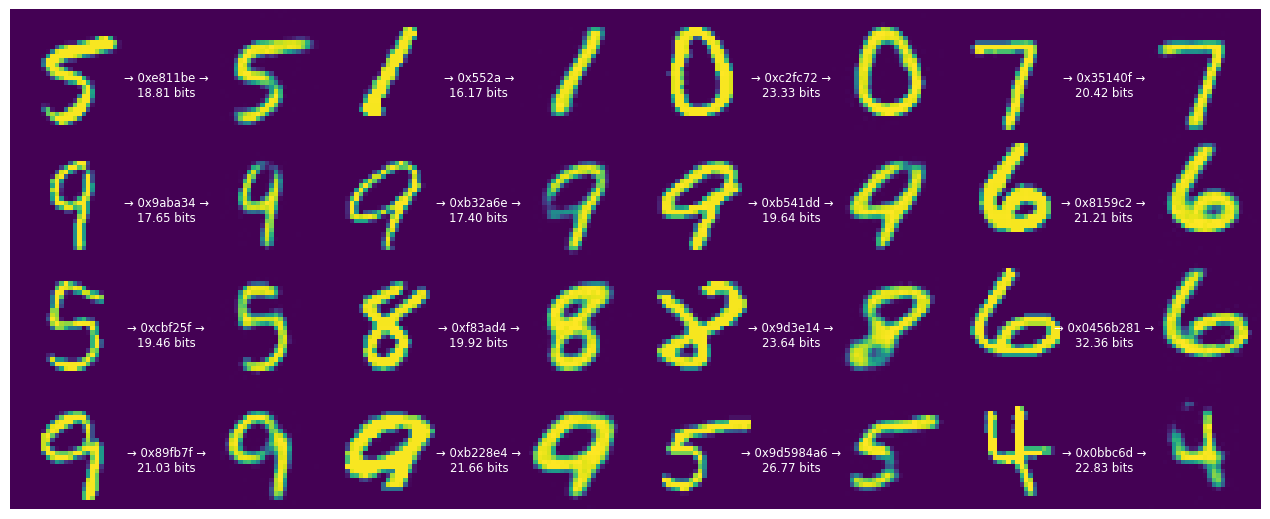

In [123]:
display_digits(originals,strings,entropies,reconstructions)